# introduction

In the next notebook, we will identify fruits with the help
 transfer learning on the RESNET network trained on the data set Imagenet.

Fruit 360 dataset is a collection of over 90,000 images of 131 different fruits.
**Our model was able to classify them with over 96% success !!!**

# Import library

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 128

In [3]:
train_path = '../input/fruits/fruits-360_dataset/fruits-360/Training'
valid_path = '../input/fruits/fruits-360_dataset/fruits-360/Test'

In [4]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [5]:
# useful for getting number of classes
folders = glob(train_path + '/*')

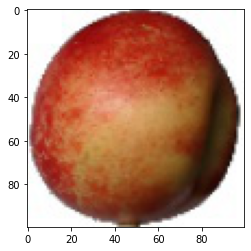

In [6]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)));

In [7]:
# resnet base
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2021-11-29 07:46:14.072576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:46:14.172724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:46:14.173567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:46:14.174712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
# don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=res.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [14]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

min: -104.779 max: 151.061


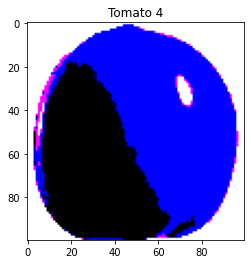

In [15]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [16]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [17]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

2021-11-29 07:46:27.043698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/16


2021-11-29 07:46:31.239885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


528/528 [==============================] - 637s 1s/step - loss: 0.7560 - accuracy: 0.9155 - val_loss: 0.8363 - val_accuracy: 0.9318
Epoch 2/16
528/528 [==============================] - 294s 556ms/step - loss: 0.2891 - accuracy: 0.9710 - val_loss: 0.6583 - val_accuracy: 0.9578
Epoch 3/16
528/528 [==============================] - 311s 588ms/step - loss: 0.2298 - accuracy: 0.9803 - val_loss: 0.7249 - val_accuracy: 0.9660
Epoch 4/16
528/528 [==============================] - 304s 576ms/step - loss: 0.1918 - accuracy: 0.9853 - val_loss: 1.0121 - val_accuracy: 0.9548
Epoch 5/16
528/528 [==============================] - 302s 572ms/step - loss: 0.2086 - accuracy: 0.9857 - val_loss: 1.2146 - val_accuracy: 0.9615
Epoch 6/16
528/528 [==============================] - 310s 587ms/step - loss: 0.1843 - accuracy: 0.9878 - val_loss: 1.2319 - val_accuracy: 0.9550
Epoch 7/16
528/528 [==============================] - 301s 570ms/step - loss: 0.1877 - accuracy: 0.9891 - val_loss: 1.0368 - val_accuracy:

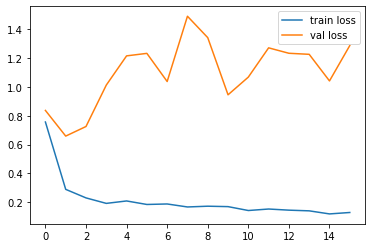

In [18]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

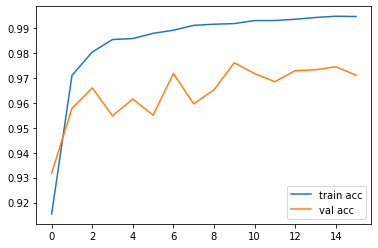

In [19]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [20]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [21]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 67692
Found 67692 images belonging to 131 classes.
12800 images processed.
25600 images processed.
38400 images processed.
51200 images processed.
64000 images processed.
[[492   0   0 ...   0   0   0]
 [  0 444   0 ...   0   0   0]
 [  0   0 480 ...   0   0   0]
 ...
 [  0   0   0 ... 474   0   0]
 [  0   0   0 ...   0 735   0]
 [  0   0   0 ...   0   0 475]]


In [22]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 22688
Found 22688 images belonging to 131 classes.
12800 images processed.
[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 444   0 ...   0   0   0]
 [  0   0 480 ...   0   0   0]
 ...
 [  0   0   0 ... 474   0   0]
 [  0   0   0 ...   0 735   0]
 [  0   0   0 ...   0   0 475]]


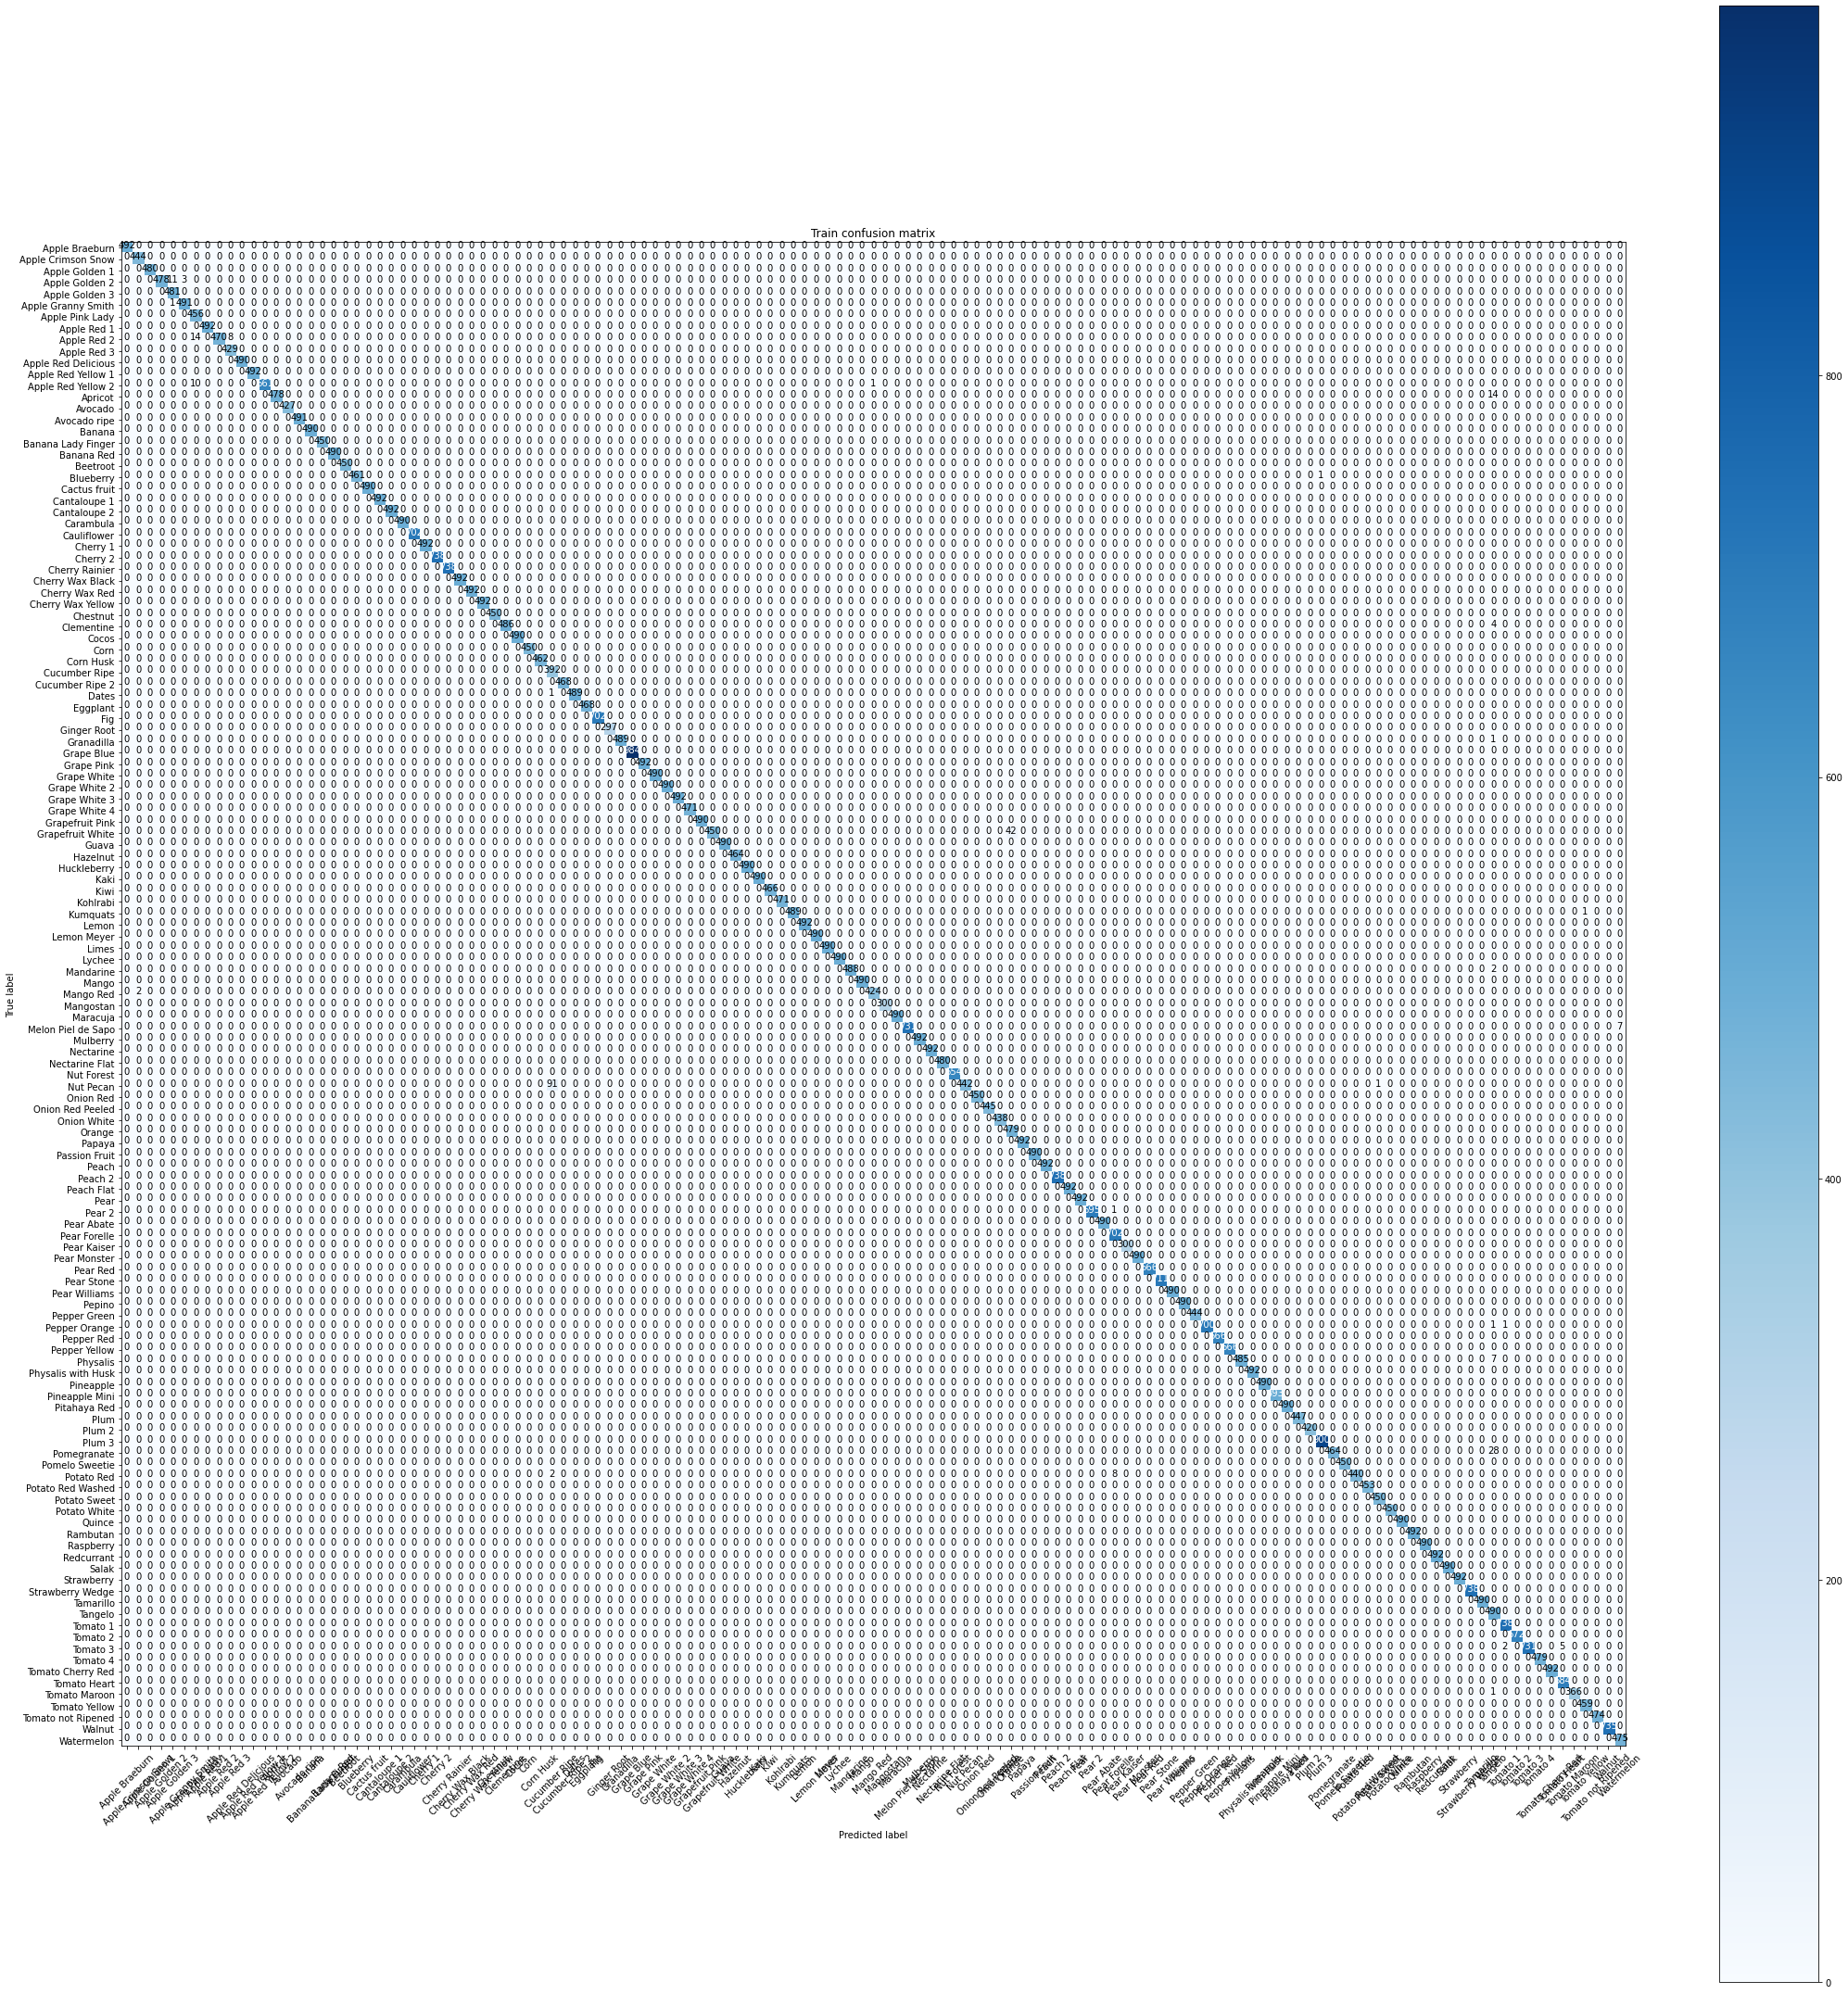

In [24]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


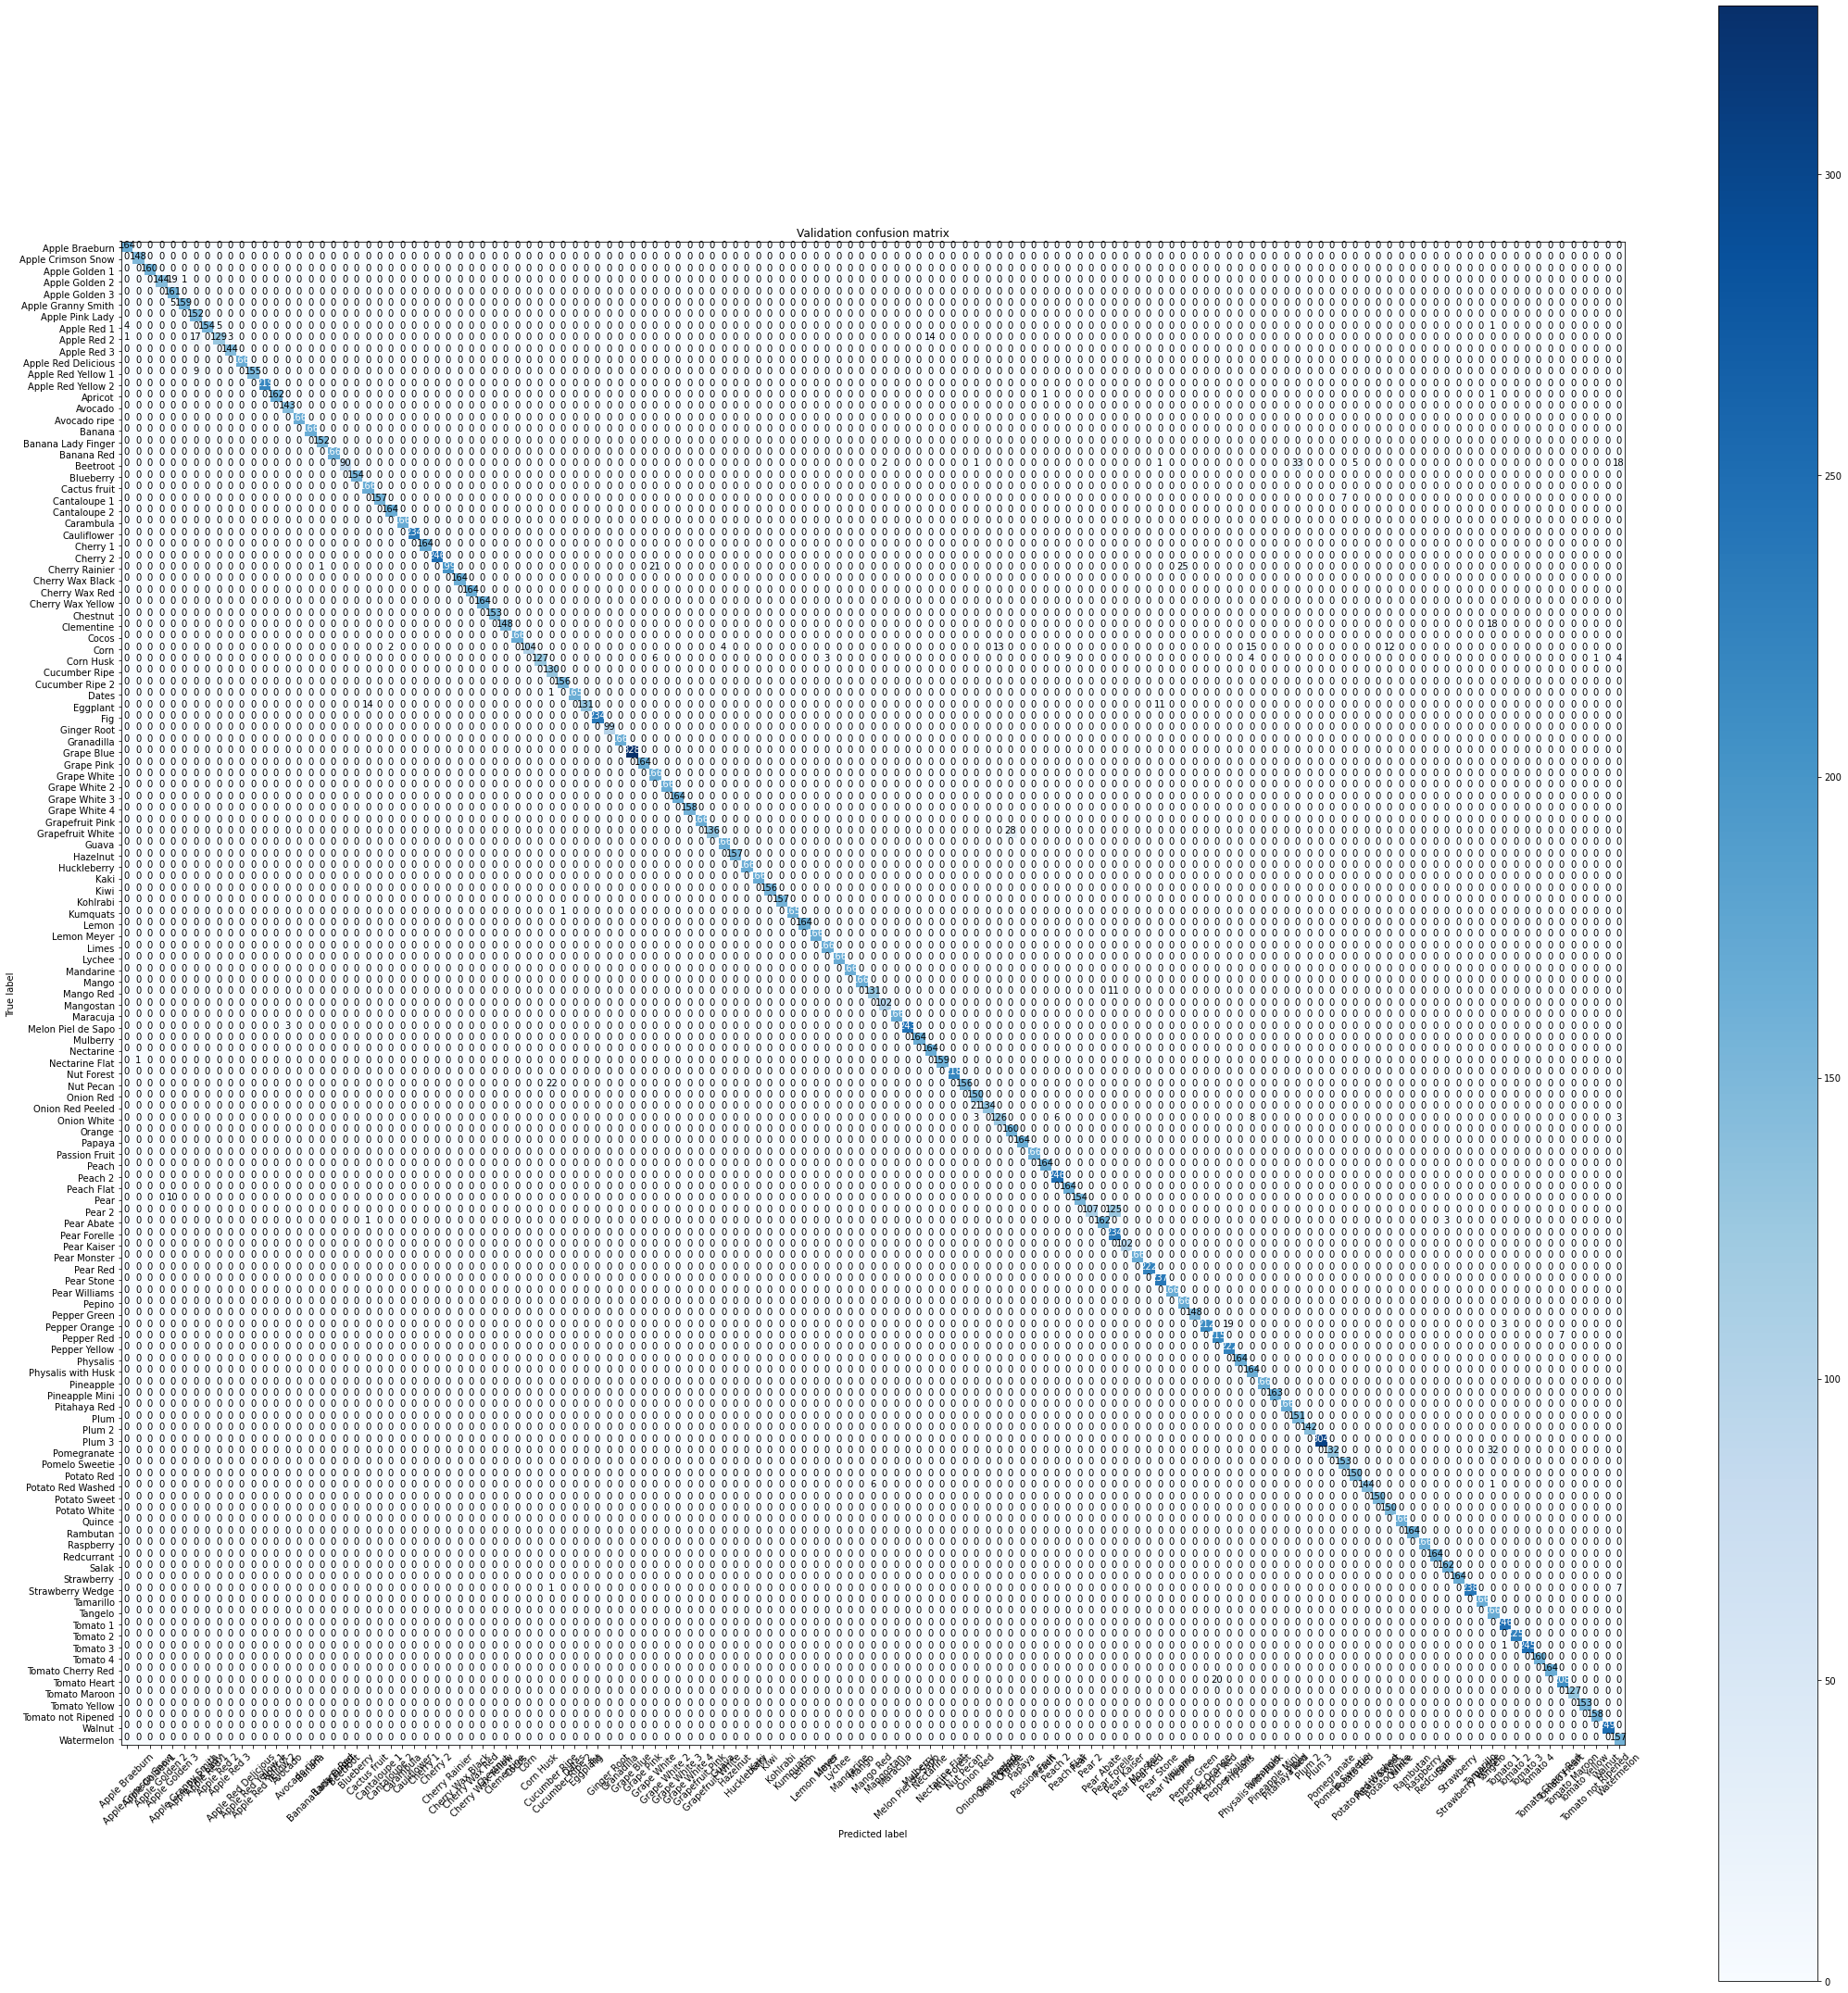

In [25]:

plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')